<a href="https://colab.research.google.com/github/Harinipraveen/Arcada-ML-projects/blob/master/patent_bigData_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#for installing bigquery client
#!pip install --upgrade google-cloud-bigquery

In [0]:
#installing biquery helper package
#!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

In [0]:
#authentication 
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'C:\Users\Harini Pravin\Downloads\My First Project-afe1694bf25a.json'

In [4]:
#authenting in google colab
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
project_id = 'brave-iterator-235513'
from google.cloud.bigquery.client import Client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [0]:
#importing basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#creating a reference for dataset
pat_dataset_ref = client.dataset('google_patents_research', project='patents-public-data')
pat_dset = client.get_dataset(pat_dataset_ref)

In [8]:
#listing out tables in the google_patents_research database
[x.table_id for x in client.list_tables(pat_dset)]

['publications',
 'publications_201710',
 'publications_201802',
 'publications_201809']

In [0]:
#table_ref = pat_dataset_ref.table("publications_201802")
#table = client.get_table(table_ref)
#df = client.list_rows(table).to_dataframe()
#df = client.query(sql).to_dataframe()

In [10]:
#selecting 200000 records from the publications_201802 table
sample_count = 200000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `patents-public-data.google_patents_research.publications_201802`''').to_dataframe().total[0]

patent = client.query('''
  SELECT
    *
  FROM
    `patents-public-data.google_patents_research.publications_201802`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)
print('our sampled dataset has %d rows' % sample_count)

Full dataset has 96018448 rows
our sampled dataset has 200000 rows


In [11]:
#estimating the query size.
#The query processed 240 GB of data
job_config = bigquery.QueryJobConfig()
job_config.dry_run = True
job_config.use_query_cache = False
query_job = client.query(
    (
        '''
  SELECT
    *
  FROM
    `patents-public-data.google_patents_research.publications_201802`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)
    ),
    job_config=job_config,
)  # API request

# A dry run query completes immediately.
assert query_job.state == "DONE"
assert query_job.dry_run

print("This query processed {} bytes.".format(query_job.total_bytes_processed))

This query processed 240130957742 bytes.


In [12]:
#printing the first 5 rows of patent dataset
patent.head()

,publication_number,title,title_translated,abstract,abstract_translated,cpc,cpc_low,cpc_inventive_low,top_terms,similar,url,country,publication_description,cited_by,embedding_v1
0,LU-24773-A,,False,,False,[],[],[],[],[],https://patents.google.com/patent/LU24773A,LUXEMBOURG,,[],[]
1,ES-492232-D0,,False,,False,[],[],[],[],[],https://patents.google.com/patent/ES492232D0,SPAIN,Patent application filed,[],[]
2,BE-823583-A1,,False,,False,[],[],[],[],[],https://patents.google.com/patent/BE823583A1,BELGIUM,Patent of invention in French,[],[]
3,BE-599023-A1,,False,,False,[],[],[],[],[],https://patents.google.com/patent/BE599023A1,BELGIUM,Patent of invention in French,[],[]
4,RU-2421199-C2,Method for prevention of silicone oil reflux i...,False,FIELD: medicine. \n SUBSTANCE: offered is ...,False,[],[],[],"[chamber, silicone, oil, anterior, method, ext...","[{'publication_number': 'US-4331130-A', 'appli...",https://patents.google.com/patent/RU2421199C2,RUSSIAN FEDERATION,Patent for invention (second publication),[],"[-0.08524717, -0.25698438, 0.05691113, -0.1336..."


In [12]:
#count of values in the publication_description column
patent['publication_description'].value_counts()

Published unexamined patent application                                                25468
Patent                                                                                 18350
Unexaminded application                                                                15691
Registered utility model                                                               11270
Patent application publication                                                         10777
Published unexamined utility model application                                          7894
Published granted patent (Second level)                                                 7577
Granted patent                                                                          6015
Patent ( having previously published pre-grant publication)                             5998
International application published with international search report                    5498
Patent specification                                                  

In [13]:
#dropping empty and unwanted columns
patent.drop(['title_translated','abstract','abstract_translated','cpc','cpc_low','cpc_inventive_low','similar','url','cited_by','embedding_v1'],1,inplace=True)
patent.columns

Index(['publication_number', 'title', 'top_terms', 'country',
       'publication_description'],
      dtype='object')

In [0]:
#limiting the no of value counts. Only those with value counts above 1000 will be retained
patent = patent.groupby('publication_description').filter(lambda x: len(x) > 1000)

In [15]:
patent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178655 entries, 20567 to 199221
Data columns (total 5 columns):
publication_number         178655 non-null object
title                      178655 non-null object
top_terms                  178655 non-null object
country                    178655 non-null object
publication_description    178655 non-null object
dtypes: object(5)
memory usage: 8.2+ MB


In [16]:
patent.isnull().values.any()

False

In [17]:
#patent release by country wise
patent['country'].value_counts()

JAPAN                       50485
CHINA                       35255
USA                         32245
EUROPEAN PATENT OFFICE      12714
FEDERAL REPUBLIC GERMANY    11606
REPUBLIC OF KOREA            8403
UNITED KINGDOM               7667
WIPO (PCT)                   6687
CANADA                       6292
FRANCE                       5782
BELGIUM                      1186
RUSSIAN FEDERATION            160
FINLAND                       154
SPAIN                          13
NETHERLANDS                     6
Name: country, dtype: int64

In [18]:
#revised value counts of publication_description
patent['publication_description'].value_counts()

Published unexamined patent application                                         25468
Patent                                                                          18350
Unexaminded application                                                         15691
Registered utility model                                                        11270
Patent application publication                                                  10777
Published unexamined utility model application                                   7894
Published granted patent (Second level)                                          7577
Granted patent                                                                   6015
Patent ( having previously published pre-grant publication)                      5998
International application published with international search report             5498
Patent specification                                                             5112
Publication of application with search report         

[Text(0, 0, 'FEDERAL REPUBLIC GERMANY'),
 Text(0, 0, 'CANADA'),
 Text(0, 0, 'USA'),
 Text(0, 0, 'RUSSIAN FEDERATION'),
 Text(0, 0, 'CHINA'),
 Text(0, 0, 'JAPAN'),
 Text(0, 0, 'EUROPEAN PATENT OFFICE'),
 Text(0, 0, 'FINLAND'),
 Text(0, 0, 'NETHERLANDS'),
 Text(0, 0, 'BELGIUM'),
 Text(0, 0, 'UNITED KINGDOM'),
 Text(0, 0, 'REPUBLIC OF KOREA'),
 Text(0, 0, 'SPAIN'),
 Text(0, 0, 'FRANCE'),
 Text(0, 0, 'WIPO (PCT)')]

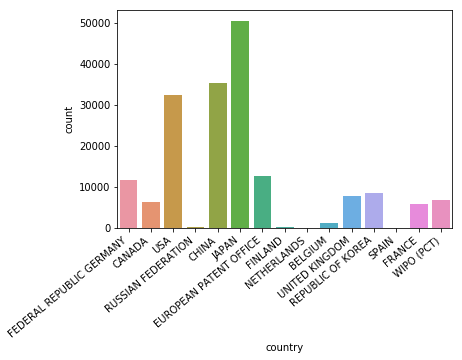

In [19]:
#plot of patent release by countrywise. Japan has max no of patents and Netherlands the least number
g = sns.countplot((patent['country']))
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

In [0]:
#removing the - from publication number column
patent['publication_number'] = patent['publication_number'].str.replace(r"-","")

In [21]:
patent.head(10)

,publication_number,title,top_terms,country,publication_description
20567,DE25634C,,[],FEDERAL REPUBLIC GERMANY,Patent
20568,CA1112671A,"Process for the recycling unreacted 1, 2- dich...","[ethane, dichloro, chlorine, weight, reacted, ...",CANADA,Patent
20569,CA345265A,Tube and bar assembling device,"[tube, bar, assembling, device, bar assembling...",CANADA,Patent
20570,CA594340A,Ferroelectric storage circuit,"[ferroelectric, storage, circuit, ferroelectri...",CANADA,Patent
20571,CA718784A,Elevatable trailers,"[elevatable, trailers, elevatable trailers]",CANADA,Patent
20572,CA763804A,Method and apparatus for the processing of und...,"[automatic, apparatus, processing, undesired, ...",CANADA,Patent
20573,CA2069617C,Switching device comprising an auxiliary monos...,"[switch, device, coupled, auxiliary, monostabl...",CANADA,Patent
20574,CA992990A,Recovery of reaction products of hydrazine and...,"[recovery, reaction, products, hydrazine, carb...",CANADA,Patent
20575,CA959167A,Single wall domain arrangement,"[single, wall, domain, arrangement, single wal...",CANADA,Patent
20576,CA2687437C,Aircraft structural element located at the int...,"[element, fin, web, provided, profiled, struct...",CANADA,Patent


In [0]:
#importing NLP library
import nltk

In [23]:
#importing stopwords package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import string
from nltk.corpus import stopwords

In [0]:
#stopwords.words('english')

In [0]:
def text_process(topic):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in topic if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [0]:
#importing neccessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [28]:
#convert a collection of text to a matrix of token counts
bow_transformer = CountVectorizer(analyzer=text_process).fit(patent['publication_description'])
print('total number of vocab words:',len(bow_transformer.vocabulary_))
patent_bow = bow_transformer.transform(patent['publication_description'])
print('Shape of Sparse Matrix: ', patent_bow.shape)
print('Amount of Non-Zero occurences: ', patent_bow.nnz)

total number of vocab words: 52
Shape of Sparse Matrix:  (178655, 52)
Amount of Non-Zero occurences:  608733


In [0]:
#Weigh the counts and normalize the vectors to unit length, to abstract from the original text length
tfidf_transformer = TfidfTransformer().fit(patent_bow)
patent_tfidf = tfidf_transformer.transform(patent_bow)

In [30]:
# Use davies_bouldin_score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,10)
results = {}
for size in num_clusters:
    model = KMeans(n_clusters = size).fit(patent_tfidf)
    predictions = model.predict(patent_tfidf)
    results[size] = davies_bouldin_score(patent_tfidf.toarray(), predictions)
  

best_size = max(results, key=results.get)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_di

In [31]:
print('The ideal number of clusters to be used based on DB index is {}:'.format(best_size))

The ideal number of clusters to be used based on DB index is 3:


In [0]:
#fitting kmeans clustering with 3 clusters
kmeans = KMeans(n_clusters = 3)
kmeans.fit(patent_tfidf)
pred = kmeans.predict(patent_tfidf)

In [34]:
#Estimating DB index for 3 clusters
DBscore = davies_bouldin_score(patent_tfidf.toarray(), pred)
print('The DB index for cluster size of 3 is',DBscore)

The DB index for cluster size of 3 is 1.8104388159128624


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [0]:
#adding the predicted labels as a column to the patent dataset to find out the data points in each cluster
patent['cls'] = pred

In [36]:
#the types of publication in cluster 0
patent[patent['cls']==0]['publication_description'].value_counts()

Published unexamined patent application                                         25468
Unexaminded application                                                         15691
Published granted patent (Second level)                                          7577
Granted patent                                                                   6015
International application published with international search report             5498
Publication of application with search report                                    4841
Official gazette of the unexamined patents                                       4748
Granted patent for invention                                                     4398
Published patent application                                                     4318
Doc. laid open (first publication)                                               3473
Published examined patent application (Second level)                             2725
Laid-open patent application                          

In [37]:
print('The total no of patents in the first cluster', sum(patent['cls']==0))

The total no of patents in the first cluster 103300


In [38]:
#patent dataset belonging to cluster 0
patent[patent['cls']==0]

,publication_number,title,top_terms,country,publication_description,cls
38917,USD314375S,Video display,"[fig, view, elevational, side, design, left, f...",USA,Design patent,0
38918,USD273522S,Hand cart,"[fig, view, isometric, elevational, hand, desi...",USA,Design patent,0
38919,USD744044S,Gaming controller adapter,"[fig, adapter, gaming, controller, shown, view...",USA,Design patent,0
38920,USD521941S,Connector housing cap,"[view, fig, elevational, side, housing, connec...",USA,Design patent,0
38921,USD746710S,Alarm system,"[view, fig, elevational, system, front, design...",USA,Design patent,0
38922,USD302735S,Adjustable table lamp,"[fig, view, scale, enlarged, elevational, lamp...",USA,Design patent,0
38923,USD700436S,Toothbrush head,"[fig, view, head, toothbrush, side, design, sh...",USA,Design patent,0
38924,USD693960S,Baffle for luminaire,"[fig, view, luminaire, baffle, elevation, desi...",USA,Design patent,0
38925,USD304573S,Swim platform,"[fig, view, platform, swim, plan, elevational,...",USA,Design patent,0
38926,USD267668S,End plate for flood light housing,"[fig, plate, view, end, housing, showing, floo...",USA,Design patent,0


[Text(0, 0, 'Design patent'),
 Text(0, 0, 'Granted patent'),
 Text(0, 0, 'Application for patent'),
 Text(0, 0, 'Unexaminded application'),
 Text(0, 0, 'Laid-open patent application'),
 Text(0, 0, 'Published patent application'),
 Text(0, 0, 'Granted EP number in Bulletin'),
 Text(0, 0, 'Granted patent for invention '),
 Text(0, 0, 'Laid open (first publication)'),
 Text(0, 0, 'Doc. laid open (first publication)'),
 Text(0, 0, 'Separately published search report'),
 Text(0, 0, 'Published granted patent (Second level)'),
 Text(0, 0, 'Published unexamined patent application'),
 Text(0, 0, 'Official gazette of the unexamined patents'),
 Text(0, 0, 'Publication of application with search report'),
 Text(0, 0, 'Separately published supplemental search report'),
 Text(0, 0, 'Later publication of ISR with revised front page'),
 Text(0, 0, 'Publication of application without search report'),
 Text(0, 0, 'Published examined patent application (Second level)'),
 Text(0, 0, 'Application for paten

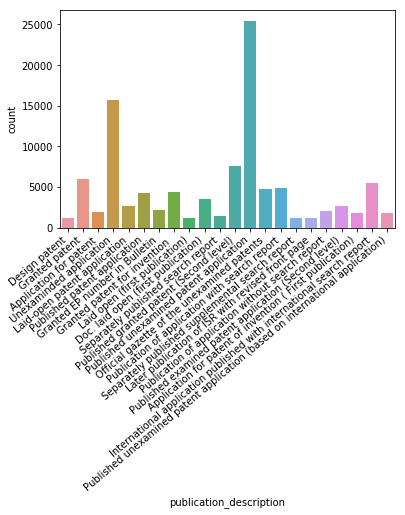

In [39]:

#count plot for patents in cluster 0
g = sns.countplot(patent[patent['cls']==0]['publication_description'])
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

In [40]:
# the patents in the cluster 1
patent[patent['cls']==1]['publication_description'].value_counts()

Registered utility model                               11270
Published unexamined utility model application          7894
Utility model                                           2863
Granted utility model                                   2698
Published utility model registration (Second level)     2415
Name: publication_description, dtype: int64

In [48]:
print('The total no of patents in the second cluster', sum(patent['cls']==1))

The total no of patents in the second cluster 27140


In [41]:
#patent dataset belonging to cluster 1
patent[patent['cls']==1]

,publication_number,title,top_terms,country,publication_description,cls
47341,DE7048063U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47342,DE7431264U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47343,DE1377874U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47344,DE1421717U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47345,DE1459364U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47346,DE1533179U,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47347,DE1667496U,Means for Embau a ground wheel driven by binde...,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47348,DE9105462U1,,[],FEDERAL REPUBLIC GERMANY,Utility model,1
47349,DE202011000728U1,"Pancreatin pellets, in particular pancreatin m...",[],FEDERAL REPUBLIC GERMANY,Utility model,1
47350,DE1668324U,Dyeing machine for fiber material.,[],FEDERAL REPUBLIC GERMANY,Utility model,1


[Text(0, 0, 'Utility model '),
 Text(0, 0, 'Granted utility model'),
 Text(0, 0, 'Registered utility model'),
 Text(0, 0, 'Published unexamined utility model application'),
 Text(0, 0, 'Published utility model registration (Second level)')]

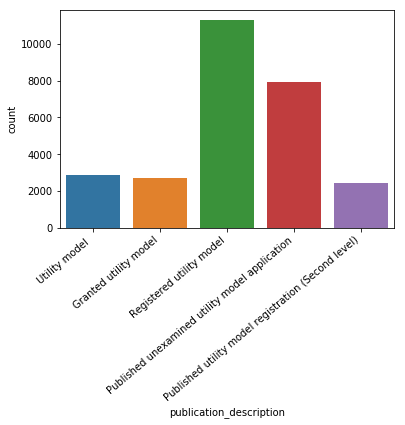

In [44]:
#count plot of patents in cluster 1
g = sns.countplot(patent[patent['cls']==1]['publication_description'])
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

In [45]:
#the patents in the cluster 2
patent[patent['cls']==2]['publication_description'].value_counts()

Patent                                                         18350
Patent application publication                                 10777
Patent ( having previously published pre-grant publication)     5998
Patent specification                                            5112
Patent of invention ( First publication)                        2665
Patent ( no pre-grant publication)                              1604
Patent of invention ( Second publication)                       1325
Granted Patent                                                  1198
Patent undefined                                                1186
Name: publication_description, dtype: int64

In [49]:
print('The total no of patents in the third cluster', sum(patent['cls']==2))

The total no of patents in the third cluster 48215


In [46]:
#patent dataset belonging to cluster 2
patent[patent['cls']==2]

,publication_number,title,top_terms,country,publication_description,cls
20567,DE25634C,,[],FEDERAL REPUBLIC GERMANY,Patent,2
20568,CA1112671A,"Process for the recycling unreacted 1, 2- dich...","[ethane, dichloro, chlorine, weight, reacted, ...",CANADA,Patent,2
20569,CA345265A,Tube and bar assembling device,"[tube, bar, assembling, device, bar assembling...",CANADA,Patent,2
20570,CA594340A,Ferroelectric storage circuit,"[ferroelectric, storage, circuit, ferroelectri...",CANADA,Patent,2
20571,CA718784A,Elevatable trailers,"[elevatable, trailers, elevatable trailers]",CANADA,Patent,2
20572,CA763804A,Method and apparatus for the processing of und...,"[automatic, apparatus, processing, undesired, ...",CANADA,Patent,2
20573,CA2069617C,Switching device comprising an auxiliary monos...,"[switch, device, coupled, auxiliary, monostabl...",CANADA,Patent,2
20574,CA992990A,Recovery of reaction products of hydrazine and...,"[recovery, reaction, products, hydrazine, carb...",CANADA,Patent,2
20575,CA959167A,Single wall domain arrangement,"[single, wall, domain, arrangement, single wal...",CANADA,Patent,2
20576,CA2687437C,Aircraft structural element located at the int...,"[element, fin, web, provided, profiled, struct...",CANADA,Patent,2


[Text(0, 0, 'Patent'),
 Text(0, 0, 'Granted Patent'),
 Text(0, 0, 'Patent undefined'),
 Text(0, 0, 'Patent specification'),
 Text(0, 0, 'Patent application publication'),
 Text(0, 0, 'Patent ( no pre-grant publication)'),
 Text(0, 0, 'Patent of invention ( First publication)'),
 Text(0, 0, 'Patent of invention ( Second publication)'),
 Text(0, 0, 'Patent ( having previously published pre-grant publication)')]

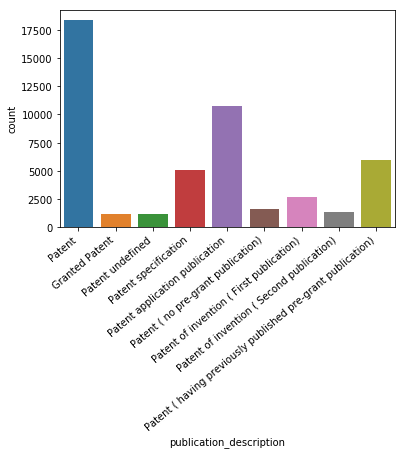

In [47]:
#count plot of patents in cluster 2
g = sns.countplot(patent[patent['cls']==2]['publication_description'])
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")